# Data Cleaning Notebook.

This notebook contains: 
- The code to read-in and clean the data for our modeling purposes.
- Basic information on the dataset.
- EDA.

## <a href="https://github.com/JK-Future-GitHub/NBA_MVP">Data Source</a>:

### <a href="https://www.basketball-reference.com/about/glossary.html">Variable Definitions</a>:

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import randint
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv('mvp_data.csv')

In [3]:
df.columns

Index(['name', 'height', 'weight', 'Season', 'Age', 'Pos', 'G', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'Rank', 'mvp_share', 'Trp Dbl',
       'conference', 'W', 'Rk_Year', 'Overall'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23057 entries, 0 to 23056
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        23057 non-null  object 
 1   height      23057 non-null  int64  
 2   weight      23054 non-null  float64
 3   Season      23057 non-null  int64  
 4   Age         23057 non-null  int64  
 5   Pos         23057 non-null  object 
 6   G           23057 non-null  int64  
 7   GS          17766 non-null  float64
 8   MP          22699 non-null  float64
 9   FG          23057 non-null  float64
 10  FGA         23057 non-null  float64
 11  FG%         22986 non-null  float64
 12  3P          18288 non-null  float64
 13  3PA         18288 non-null  float64
 14  3P%         15541 non-null  float64
 15  2P          19690 non-null  float64
 16  2PA         19690 non-null  float64
 17  2P%         19579 non-null  float64
 18  eFG%        19622 non-null  float64
 19  FT          23057 non-nul

---

# Cleaning:

In [35]:
# Fill missing values
df['Rank'].fillna(0, inplace=True)
df['mvp_share'].fillna(0.0, inplace=True)
df['Trp Dbl'].fillna(0, inplace=True)

# Normalize Triple Double
df['Trp Dbl'] = df['Trp Dbl'] / df['G']

# Convert 'G' and 'Season' to integer type
df['G'] = df['G'].astype(int)
df['Season'] = df['Season'].astype(int)

# Filter out data based on conditions
df = df[(df['G'] > 40) & (df['Season'] <= 2022)]

# Ranking Conference
df['Rk_Conf'] = df.groupby(['Season', 'conference'])['W'].rank("dense", ascending=False) + df['Rk_Year']
df['Rk_Conf'] = df.groupby(['Season', 'conference'])['Rk_Conf'].rank("dense", ascending=True)

# Drop Wins and Conference
df.drop(columns=['conference', 'W'], inplace=True)

# Sort out seasons we'll use for testing/predictions
df.sort_values(by=['Season'], ascending=False, inplace=True)
df_last = df[df['Season'] > (2022 - 5)] 
last_names = df_last['name'].values
last_seasons = df_last['Season'].values
del df_last['name']
del df_last['Season']
del df_last['Rank']
del df_last['mvp_share']

# Filter for seasons older than 5 years
df = df[df['Season'] <= (2022 - 5)]
df.drop(columns=['name'], inplace=True)

In [36]:
last_names = pd.DataFrame(last_names, columns=['name'])
last_seasons = pd.DataFrame(last_seasons, columns=['Season'])
last_names.to_csv('last_names.csv', index=False)
last_seasons.to_csv('last_seasons.csv', index=False)

In [38]:
df.isnull().sum()

height          0
weight          0
Season          0
Age             0
Pos             0
G               0
GS           4210
MP            265
FG              0
FGA             0
FG%             0
3P           3805
3PA          3805
3P%          4890
2P           2629
2PA          2629
2P%          2629
eFG%         2629
FT              0
FTA             0
FT%             2
ORB          2547
DRB          2547
TRB           169
AST             0
STL          2547
BLK          2547
TOV          3345
PF              0
PTS             0
PER           265
TS%             0
3PAr         3805
FTr             0
ORB%         2547
DRB%         2547
TRB%         2034
AST%         1344
STL%         2547
BLK%         2547
TOV%         3345
USG%         3345
OWS             0
DWS             0
WS              0
WS/48         265
OBPM         2547
DBPM         2547
BPM          2547
VORP         2547
Rank            0
mvp_share       0
Trp Dbl         0
Rk_Year         0
Overall         0
Rk_Conf   

### There are a lot of missing values, so we must further clean and investigate. 

Three-point shots weren't introduced until 1979-80, and there are a lot of missing values before then, so we drop any season < 1980.

In [39]:
df = df[df['Season'] >= 1980]
df.drop(['Season'], axis="columns", inplace=True)

In [42]:
df.to_csv('df_clean.csv', index=False)
df_last.to_csv('df_last.csv', index=False)

In [43]:
df.isnull().sum()

height          0
weight          0
Age             0
Pos             0
G               0
GS            430
MP              0
FG              0
FGA             0
FG%             0
3P              0
3PA             0
3P%          1085
2P              0
2PA             0
2P%             0
eFG%            0
FT              0
FTA             0
FT%             2
ORB             0
DRB             0
TRB             0
AST             0
STL             0
BLK             0
TOV             0
PF              0
PTS             0
PER             0
TS%             0
3PAr            0
FTr             0
ORB%            0
DRB%            0
TRB%            0
AST%            0
STL%            0
BLK%            0
TOV%            0
USG%            0
OWS             0
DWS             0
WS              0
WS/48           0
OBPM            0
DBPM            0
BPM             0
VORP            0
Rank            0
mvp_share       0
Trp Dbl         0
Rk_Year         0
Overall         0
Rk_Conf         0
dtype: int

## There are still some null values: 
* 430 GS (games started)
* 1085 3P% (3-point percent)
* 2 for FT% (free throw percent)

We create a separate dataframe and fill these missing values with 0 for now, but we revisit this later in `preptrain.py` using imputation.

In [13]:
df_corr = df.copy()
df_corr.fillna(0, inplace=True)
# Drop position column for corrplot below
df_corr.drop(['Pos'], axis="columns", inplace=True)

# EDA 

### `Pandas_Profiling`

If you want this to run faster, set `minimal=True`

In [15]:
profile = ProfileReport(df, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()

# Save the report as an HTML file
profile.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### sns `Corrplot`

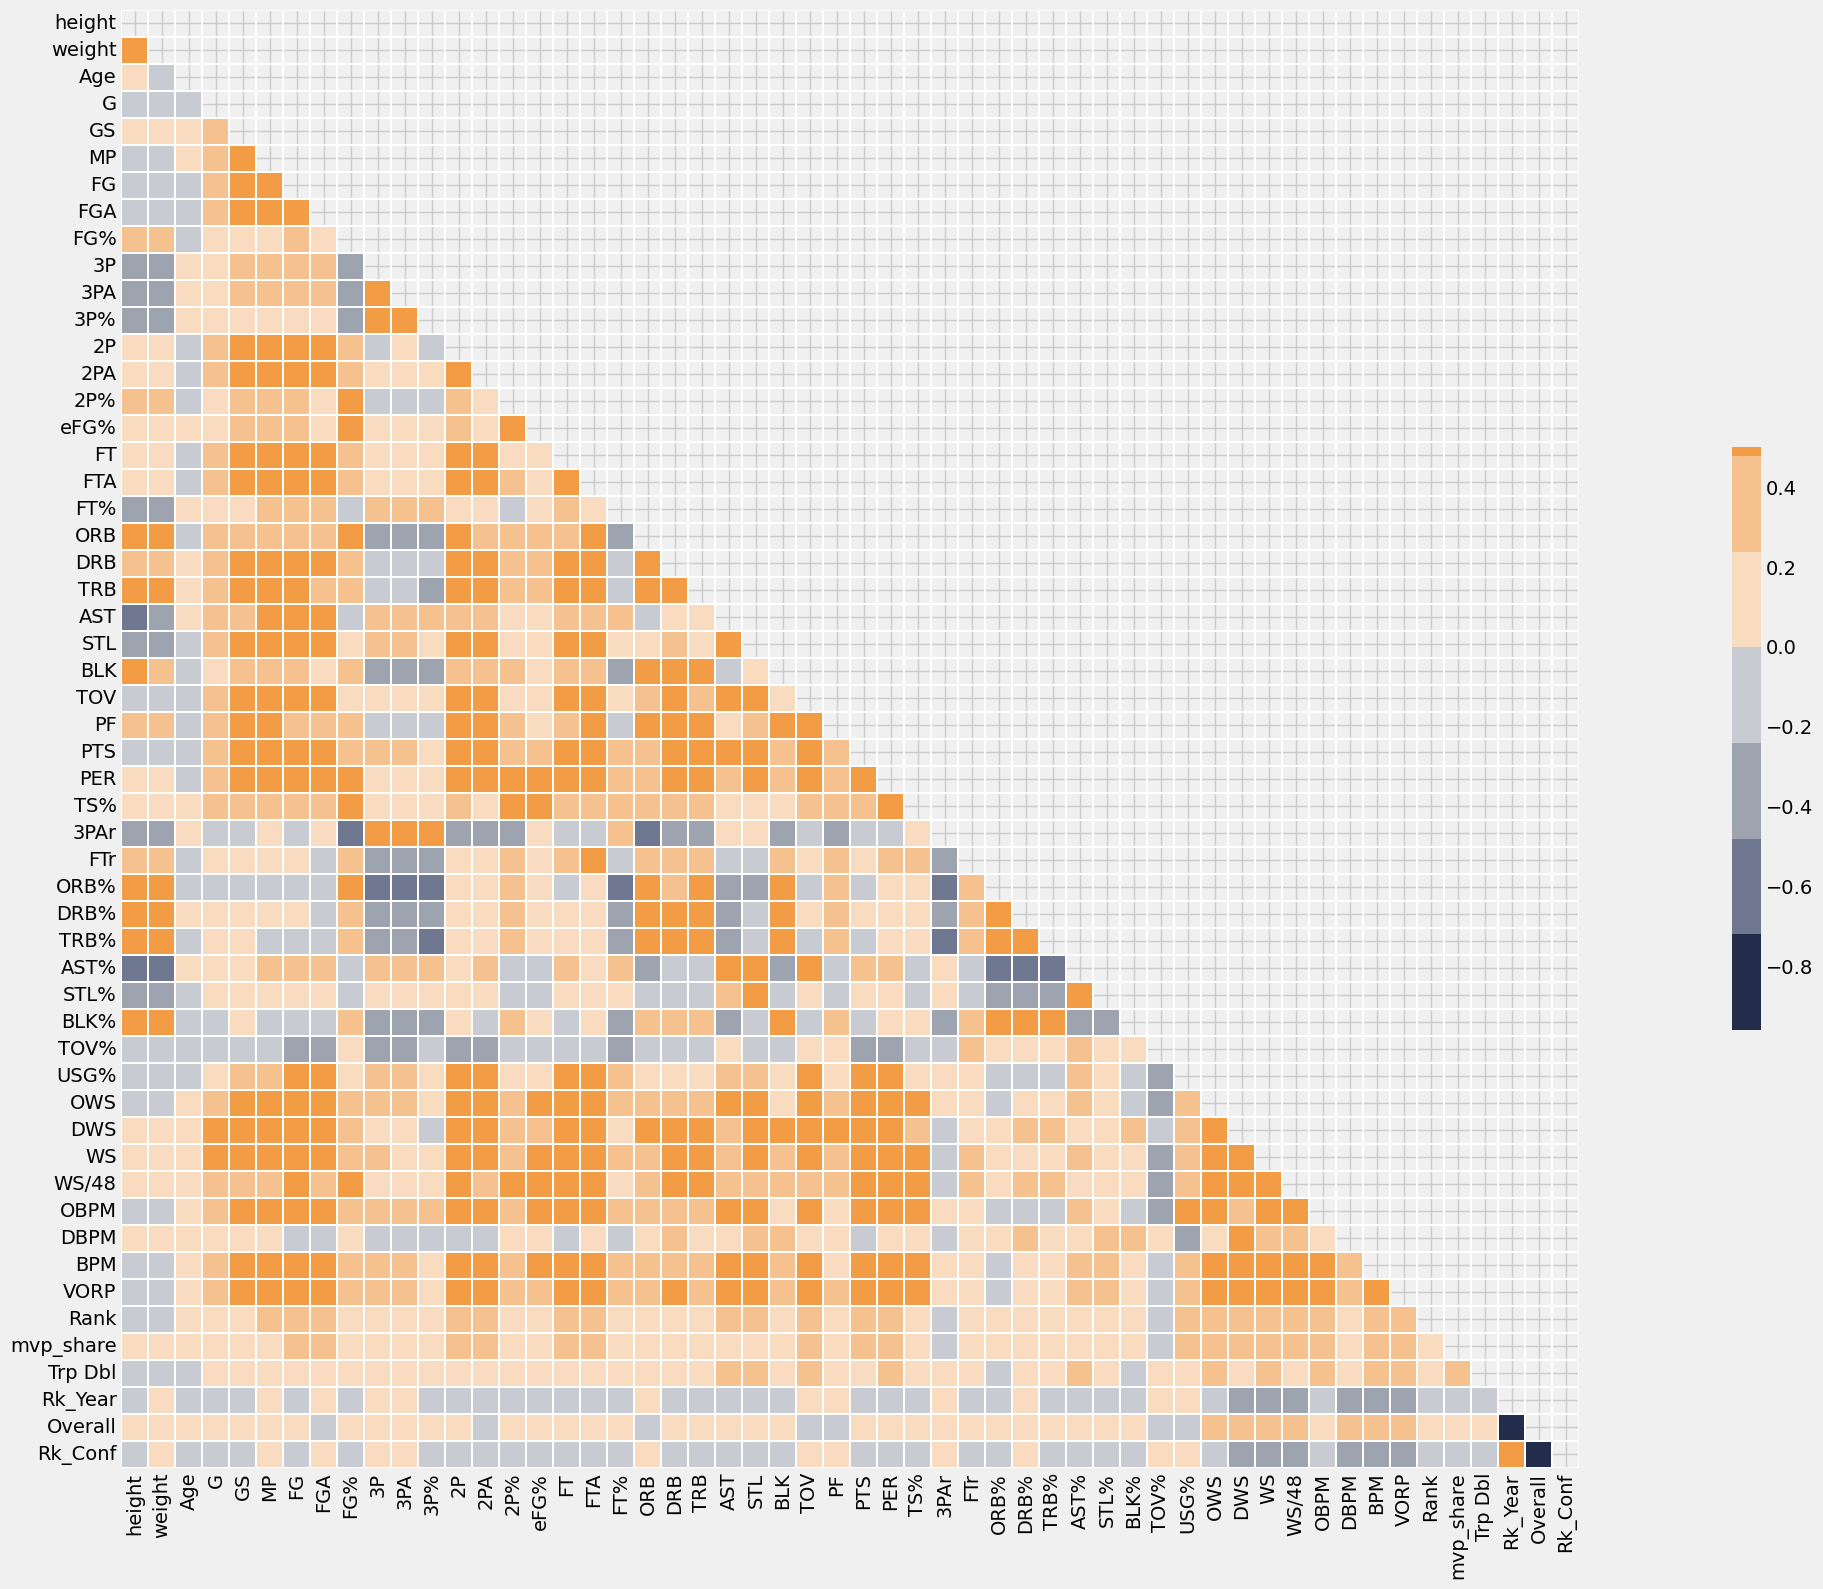

In [14]:
# Set the style to FiveThirtyEight
plt.style.use('fivethirtyeight')

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35, 18))

# Custom colormap
cmap = ListedColormap(['#232D4B', '#6f7890', '#9ea3b0', '#C8CBD2', 
                       '#F9DCBF', '#f4c18f', '#f29c46', '#de6e00'])

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .4})

plt.show()